## Long Pulse Lagged Product Arrays

The RADAC mode "s" is built for uncoded single pulses (e.g. long pulses). In these cases there is no need to worry about any phase codes. We define the lag product array (LPA) at range $i$ and lag $\ell$ as:
$$L_{\ell}^i \equiv V_{i-\left \lfloor \frac{\ell}{2}\right\rfloor}^* V_{i+\left \lfloor \frac{\ell}{2}\right\rfloor + (\ell \bmod 2)},$$
where $V_i$ denotes the complex voltage sample from range $i$. Some other authors defined the LPA as:
$$L_{\ell}^i \equiv V_{i}^* V_{i+\ell}.$$
The avoid confusion, I will refer to this alternate form as the unshifted LPA and our standard version as the shifted LPA. The shifted LPA is just a rearrangement of the unshifted LPA. The point of the index shifts are to cause the lagged products associated with index $i$ to all be centered on approximately the same range. Note that issues with integer division mean that the true center range of the odd-numbered lagged is actually half a sample higher than the even number lags. For example
$$
\begin{align*}
L^i_0 &= V_{i}^* V_{i} \\
L^i_1 &= V_{i}^* V_{i+1} \\
L^i_2 &= V_{i-1}^* V_{i+1} \\
L^i_3 &= V_{i-1}^* V_{i+2} \\
\text{etc.}
\end{align*}
$$
The zeroth lag of the LPA is simply the signal power.

# Contents of the S folder
A typical experiment will use the "s" mode to process a number of different types of samples (e.g. Data, Noise, Cal). A typical long pulse file will have folders for each of these types of samples labeled:

* /S/Data/
* /S/Noise/
* /S/Cal/

Within those folders there will be the following meta data:

* Ambiguity: String of the name of the ambiguity file
* Beamcodes: Nrecords x Nbeams array of beamcodes
* PulsesIntegrated: Nrecords x Nbeams array of the number of pulses summed together
* Pulsewidth: Pulse length in seconds
* TxBaud: Baud length in seconds. For an uncoded pulse, TxBaud=Pulsewidth

There will also be two subfolders, with the following contents:

* Power:
    * Data: Sum of the signal powers (Nrecords x Nbeams x Nranges)
    * Range: Range in m (1 x Nranges)
* Acf:
    * Data: The shifted LPA (Nrecords x Nbeams x Nlags x Nranges x 2). The last dimension is for the real (0) and imaginary (1) parts.
    * Lags: Lag times in s (1 x Nlags)
    * Range: Range in m (1 x Nranges)
    
If the option "poweronly=1" is set in the exp file, then the "Acf" folder will be missing. This option is commonly used for the Cal samples. The real parts of the zero lags, Acf/Data[:,:,0,:,0], will be identical to Power/Data[:,:,:].

**A note on terminology**: Despite the name "S/Data/Acf", I prefer to call this quantity the LPA since it is not actually the autocorrelation-function of a wide-sense stationary random process. The LPA is related to the plasma ACF through the Range-Lag ambiguity functions. Many people call this quantity the ACF, but that terminology will create confusion when we talk later about constructing gated ACFs from LPA.

**Note on sums not averages**: The "s" code always sums, it never averages. The number in PulsesIntegrated[t,b] is the number of pulses in record $t$ and beam $b$ that were summed together. All of the voltage samples are stored as integers since the RADAC cards quantize the signal. This means that the LPA can be calculated using only integer arithmetic to do products and sums, which is faster and free of any loss of precision in the real-time C code. When comparing Data, Noise, and Cal, or when comparing data between different beams, pay close attention to the PulsesIntegrated array. Some experiments have different numbers of pulses sent to a particular beam within a record, or different numbers of noise/cal samples than data samples. In these cases, one needs to divide by PulsesIntegrated in order to make sensible comparisons.

In [1]:
# Download the data file that we need to run these examples
import urllib.request
url='https://data.amisr.com/database/tmp/isr_school_2020/d0048205.dt3.h5'
outputfilepath='./d0048205.dt3.h5'

print('Downloading data file...')
urllib.request.urlretrieve(url,outputfilepath)

print('...Done!')

...Done!


In [2]:
#Load an example file
import io_utils #wrapper for pytables routines

#This is one file from a WorldDay35 experiment
f=io_utils.read_whole_h5file('./d0048205.dt3.h5')

In [3]:
import numpy

#Sizes of arrays
nRecs,nPulses,nRawRanges,nIQs=f['/Raw11/Raw/Samples']['Data'].shape
nRecs,nBeams,nLags,nRanges,nIQs=f['/S/Data/Acf']['Data'].shape

#We need to be careful about off-the-end index issues
assert(nRanges==nRawRanges-nLags)
nLags2=nLags//2
r1=nLags2-1
r2=nRawRanges-nLags2-1
#reduced set of ranges for ACF
rangeAcf=f['/Raw11/Raw/Samples']['Range'][0,r1:r2]

#Allocate working arrays
acf0=1j*numpy.zeros((nPulses,nLags,nRanges))
acfInt=1j*numpy.zeros((nRecs,nBeams,nLags,nRanges))
pulsesIntegrated=numpy.zeros((nRecs,nBeams),dtype='int')

#Raw voltages
raw0=f['/Raw11/Raw/Samples']['Data'][:,:,:,0]+1j*f['/Raw11/Raw/Samples']['Data'][:,:,:,1]

#Do one record at a time to avoid excessive memory usage
for rec in range(nRecs):   
    for ell in range(nLags):
        ell2m=ell//2 #note the use of integer division
        ell2p=ell//2+ell%2
        acf0[:,ell,:]=numpy.conj(raw0[rec,:,r1-ell2m:r2-ell2m])*raw0[rec,:,r1+ell2p:r2+ell2p]
        
    #Sort by beam and integrate
    #Using the RadacHeader Beamcodes guarantees that this will work, 
    #even for exotic experiments with irregular beam revisit patterns  
    for b in range(nBeams):
        bcode=f['/S/Data']['Beamcodes'][0,b]
        ind=numpy.where(f['/Raw11/Raw/RadacHeader']['BeamCode'][rec,:]==bcode)[0]
        acfInt[rec,b,:,:]=numpy.sum(acf0[ind,:,:],axis=0)
        pulsesIntegrated[rec,b]=acf0[ind,:,:].shape[0]

In [4]:
#These checks prove that we did it right:
acfS=f['/S/Data/Acf']['Data'][:,:,:,:,0]+1j*f['/S/Data/Acf']['Data'][:,:,:,:,1]

print('S LPA:', acfS[5,1,:,150])
print('Our LPA:', acfInt[5,1,:,150])
print('Difference', acfS[5,1,:,150]-acfInt[5,1,:,150])

S LPA: [703870.    +0.j 202504.-67528.j  66274.-32959.j  23109. -4496.j
 -64491. +3895.j -98432. +5022.j -52819. -2496.j -17677.+23271.j
   7779.+89208.j  22125. +9378.j -66903.-31924.j -36225.-25274.j
   5684. -5526.j   6350.-55477.j -38053.-16613.j  53877.+20792.j]
Our LPA: [703870.    +0.j 202504.-67528.j  66274.-32959.j  23109. -4496.j
 -64491. +3895.j -98432. +5022.j -52819. -2496.j -17677.+23271.j
   7779.+89208.j  22125. +9378.j -66903.-31924.j -36225.-25274.j
   5684. -5526.j   6350.-55477.j -38053.-16613.j  53877.+20792.j]
Difference [0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j
 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j]


# Visualizing Lagged Product Arrays

The LPA is related to the plasma ACF, and you can already begin to see ionospheric features by looking directly at the LPA. There will be a bunch of junk at short ranges associated with the Tx pulse and the ground clutter, but everything above 100 km should be real ionospheric signals.

Text(0.5, 0, 'Lag (us)')

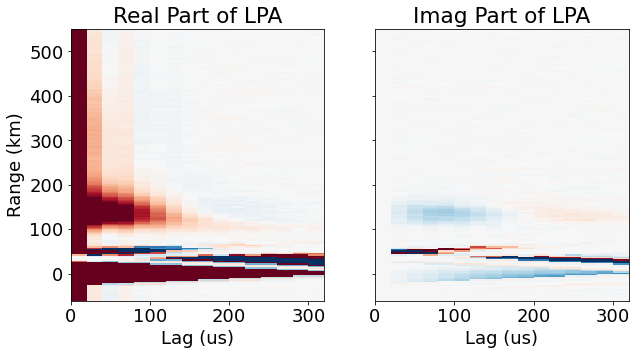

In [5]:
%matplotlib inline
import matplotlib.pyplot as plt

rng=f['/S/Data/Acf']['Range'][0,:]*1e-3 #km
lag=f['/S/Data/Acf']['Lags'][0,:]*1e6 #us

#padding tricks to get pcolormesh to actually plot the whole array
rng=numpy.concatenate((rng,numpy.array([rng[-1]+rng[-1]-rng[-2]])))
lag=numpy.concatenate((lag,numpy.array([lag[-1]+lag[-1]-lag[-2]])))

#Just pick one beam to plot
b=8

#Average over all records in the file
acf=numpy.mean(f['/S/Data/Acf']['Data'][:,b,:,:,0]+1j*f['/S/Data/Acf']['Data'][:,b,:,:,1],axis=0)

plt.rcParams['figure.figsize']=10,5
plt.rcParams['font.size']=18
fig,axarr=plt.subplots(1,2,sharey=True)
#I strongly recommend setting symmetric color limits so you can clearly see the zero crossings
vmin=-5e5
vmax=5e5
axarr[0].pcolormesh(lag,rng,acf.real.T,vmin=vmin,vmax=vmax,cmap='RdBu_r')
axarr[0].set_title('Real Part of LPA')
axarr[0].set_xlabel('Lag (us)')
axarr[0].set_ylabel('Range (km)')
axarr[1].pcolormesh(lag,rng,acf.imag.T,vmin=vmin,vmax=vmax,cmap='RdBu_r')
axarr[1].set_title('Imag Part of LPA')
axarr[1].set_xlabel('Lag (us)')

If you have a strong intution for ISR theory you can get a sense of some of the plasma parameters just by looking at the LPA. The shorter the lag of the first zero crossing, the higher the temperatures. All the information about the plasma velocity is contained in the imaginary part of the LPA. If the imaginary part goes negative-positive-negative-positive with increasing lag time, then the velocity is away from the radar (redshift).

In order to analyze the LPA quantitatively, we have to account for the effects of range-lag ambiguity function. The standard AMISR processing deals with this problem using a gated analysis. There are more sophisticated alternatives, however, such as full-profile analysis and lag-profile inversion.

## Noise Subtraction

The noise is not exactly white noise due to the impulse response of the receiver filter. We record the full noise ACF so that we can subtract it off and get just the ionospheric signal.

Text(0.5, 1.0, 'Noise ACF')

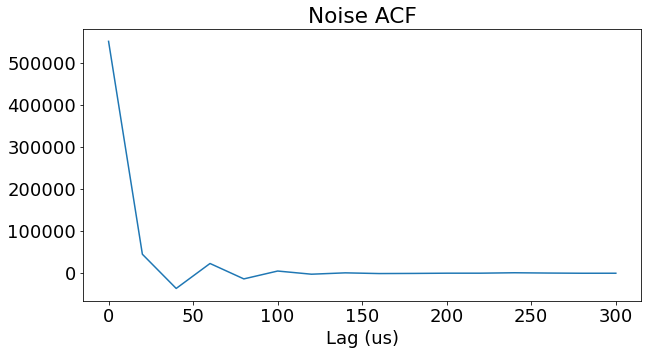

In [6]:
noiseacf=f['/S/Noise/Acf']['Data'][:,:,:,:,0]+1j*f['/S/Noise/Acf']['Data'][:,:,:,:,1]
#Take a mean over all noise ranges
noiseacfmr=numpy.mean(noiseacf,axis=-1)
#Take a mean over all records in the file
noiseacfm=numpy.mean(noiseacfmr,axis=0)

plt.rcParams['figure.figsize']=10,5
plt.rcParams['font.size']=18
plt.plot(lag[:-1],noiseacfm[0,:].real)
plt.xlabel('Lag (us)')
plt.title('Noise ACF')

Text(0.5, 0, 'Lag (us)')

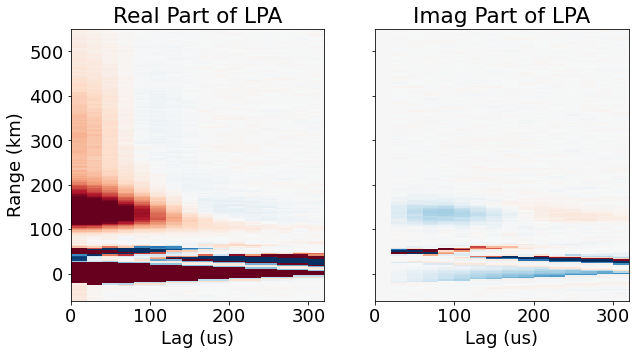

In [7]:
rng=f['/S/Data/Acf']['Range'][0,:]*1e-3 #km
lag=f['/S/Data/Acf']['Lags'][0,:]*1e6 #us

#padding tricks to get pcolormesh to actually plot the whole array
rng=numpy.concatenate((rng,numpy.array([rng[-1]+rng[-1]-rng[-2]])))
lag=numpy.concatenate((lag,numpy.array([lag[-1]+lag[-1]-lag[-2]])))

#Just pick one beam to plot
b=8

#Average over all records in the file
facf=numpy.mean(f['/S/Data/Acf']['Data'][:,b,:,:,0]+1j*f['/S/Data/Acf']['Data'][:,b,:,:,1],axis=0)

#subtract noise to get the signal acf
acf=facf-numpy.expand_dims(noiseacfm[b,:],axis=-1)

plt.rcParams['figure.figsize']=10,5
plt.rcParams['font.size']=18
fig,axarr=plt.subplots(1,2,sharey=True)
#I strongly recommend setting symmetric color limits so you can clearly see the zero crossings
#If you switch to 5e4 the F-region will become easier to see but the E-region will saturate
vmin=-5e5
vmax=5e5
axarr[0].pcolormesh(lag,rng,acf.real.T,vmin=vmin,vmax=vmax,cmap='RdBu_r')
axarr[0].set_title('Real Part of LPA')
axarr[0].set_xlabel('Lag (us)')
axarr[0].set_ylabel('Range (km)')
axarr[1].pcolormesh(lag,rng,acf.imag.T,vmin=vmin,vmax=vmax,cmap='RdBu_r')
axarr[1].set_title('Imag Part of LPA')
axarr[1].set_xlabel('Lag (us)')

Text(0.5, 0, 'Lag (us)')

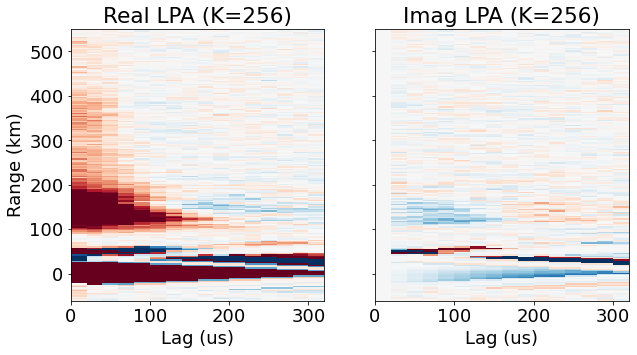

In [8]:
#This example shows how to use a custom integration time rather than following the records in the file

K=256 #user-specified number of pulses to integrate

#Sizes of arrays
nRecs,nPulses,nRawRanges,nIQs=f['/Raw11/Raw/Samples']['Data'].shape
nRecs,nBeams,nLags,nRanges,nIQs=f['/S/Data/Acf']['Data'].shape

#We need to be careful about off-the-end index issues
assert(nRanges==nRawRanges-nLags)
nLags2=nLags//2
r1=nLags2-1
r2=nRawRanges-nLags2-1
#reduced set of ranges for ACF
rangeAcf=f['/Raw11/Raw/Samples']['Range'][0,r1:r2]

#Allocate working arrays
acf0=1j*numpy.zeros((nPulses,nLags,nRanges))
acfCust=1j*numpy.zeros((1,nBeams,nLags,nRanges))
pulsesIntegratedCust=numpy.zeros((1,nBeams),dtype='int')

#Raw voltages
raw0=f['/Raw11/Raw/Samples']['Data'][:,:,:,0]+1j*f['/Raw11/Raw/Samples']['Data'][:,:,:,1]

#Do one record at a time to avoid excessive memory usage
rec=0
while(rec<nRecs and pulsesIntegratedCust[0,0]<K):   
    for ell in range(nLags):
        ell2m=ell//2 #note the use of integer division
        ell2p=ell//2+ell%2
        acf0[:,ell,:]=numpy.conj(raw0[rec,:,r1-ell2m:r2-ell2m])*raw0[rec,:,r1+ell2p:r2+ell2p]
        
    #Sort by beam and integrate
    #Using the RadacHeader Beamcodes guarantees that this will work, 
    #even for exotic experiments with irregular beam revisit patterns
    for b in range(nBeams):
        bcode=f['/S/Data']['Beamcodes'][0,b]
        ind=numpy.where(f['/Raw11/Raw/RadacHeader']['BeamCode'][rec,:]==bcode)[0]
        pulsesToDo=numpy.min((K-pulsesIntegratedCust[0,b],acf0[ind,:,:].shape[0]))
        acfCust[0,b,:,:]=acfCust[0,b,:,:]+numpy.sum(acf0[ind[:pulsesToDo],:,:],axis=0)
        pulsesIntegratedCust[0,b]=pulsesIntegratedCust[0,b]+pulsesToDo
        
    rec=rec+1
    
rng=f['/S/Data/Acf']['Range'][0,:]*1e-3 #km
lag=f['/S/Data/Acf']['Lags'][0,:]*1e6 #us

#padding tricks to get pcolormesh to actually plot the whole array
rng=numpy.concatenate((rng,numpy.array([rng[-1]+rng[-1]-rng[-2]])))
lag=numpy.concatenate((lag,numpy.array([lag[-1]+lag[-1]-lag[-2]])))

#Just pick one beam to plot
b=8

#Normalize the number of pulses Integrated for the purpose of plotting on one colorbar
facf=acfCust[0,b,:,:]/pulsesIntegratedCust[0,b]

#Noise subtraction with the pulsesIntegrated normalization done correctly
noiseacfnorm=numpy.expand_dims(noiseacfm[b,:],axis=-1)/pulsesIntegrated[0,b]

acf=facf-noiseacfnorm


plt.rcParams['figure.figsize']=10,5
plt.rcParams['font.size']=18
fig,axarr=plt.subplots(1,2,sharey=True)
#I strongly recommend setting symmetric color limits so you can clearly see the zero crossings
vmin=-3e3
vmax=3e3
axarr[0].pcolormesh(lag,rng,acf.real.T,vmin=vmin,vmax=vmax,cmap='RdBu_r')
axarr[0].set_title('Real LPA (K=%d)'%K)
axarr[0].set_xlabel('Lag (us)')
axarr[0].set_ylabel('Range (km)')
axarr[1].pcolormesh(lag,rng,acf.imag.T,vmin=vmin,vmax=vmax,cmap='RdBu_r')
axarr[1].set_title('Imag LPA (K=%d)'%K)
axarr[1].set_xlabel('Lag (us)')

#plt.savefig('LPA_K%d.eps'%K,format='eps',dpi=300,bbox_inches='tight')